In this section, I am importing the dataset and the libraries that I will need for my model.

In [ ]:
import os
import pickle
!wget -O images_data.pkl 'http://frasca.di.unimi.it/images_data.pkl'
print(os.listdir()) # you should see the file
with open('images_data.pkl', 'rb') as f:
    data=pickle.load(f)

--2023-08-25 14:53:23--  http://frasca.di.unimi.it/images_data.pkl
Resolving frasca.di.unimi.it (frasca.di.unimi.it)... 159.149.130.139
Connecting to frasca.di.unimi.it (frasca.di.unimi.it)|159.149.130.139|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://frasca.di.unimi.it/images_data.pkl [following]
--2023-08-25 14:53:26--  https://frasca.di.unimi.it/images_data.pkl
Connecting to frasca.di.unimi.it (frasca.di.unimi.it)|159.149.130.139|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 134290382 (128M)
Saving to: ‘images_data.pkl’

images_data.pkl     100%[===================>] 128.07M  19.3MB/s    in 7.7s    

2023-08-25 14:53:34 (16.7 MB/s) - ‘images_data.pkl’ saved [134290382/134290382]

['.config', 'images_data.pkl', 'sample_data']


In [ ]:
import numpy as np
import pandas as pd
import keras
from keras import layers
import itertools
import random
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Input, Dense, LeakyReLU, Reshape, Conv2D, MaxPooling2D, UpSampling2D,
    Dropout, Flatten, BatchNormalization
)
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import he_normal
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, mean_squared_error
import zipfile
import os

np.random.seed(42)

#1. Input

In [ ]:
images = data['imgs']
labels = data['labels']
bboxes = data['bboxes']

In [ ]:
images, labels, bboxes = shuffle(images, labels, bboxes, random_state = 31)
images = np.array(images)
bboxes = np.array(bboxes)

<ipython-input-4-cb2778e8a12f>:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  bboxes = np.array(bboxes)


As I said in my exam, I will implement a ```
MinMaxScaler``` in order to have all the pixel in a range that goes [0, 1].


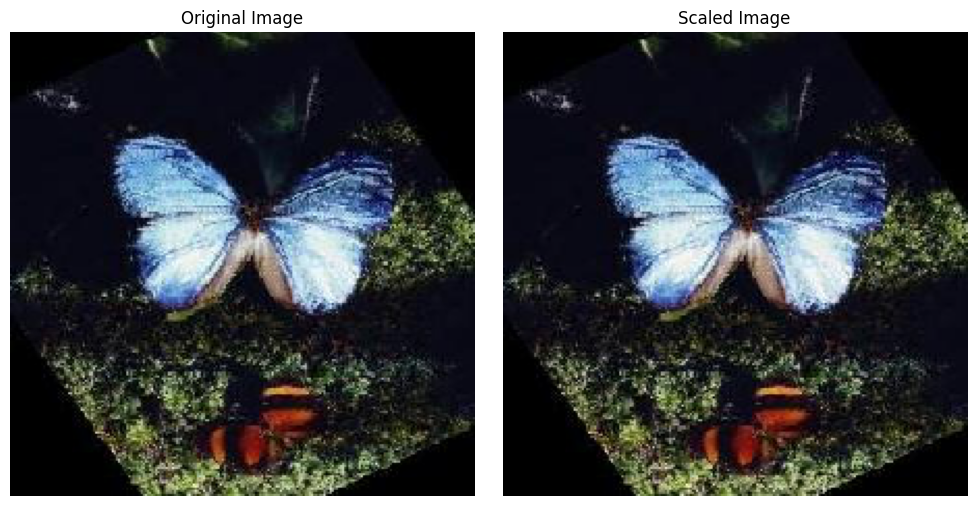

In [ ]:
mmscaler = MinMaxScaler()

new_images = [mmscaler.fit_transform(image.reshape(-1, 3)).reshape(224, 224, 3) for image in images]

original_image = images[4]
scaled_image = new_images[4]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

for ax, img, title in zip(axes, [original_image.astype('uint8'), scaled_image], ["Original Image", "Scaled Image"]):
    ax.imshow(img)
    ax.set_title(title)
    ax.axis('off')

plt.tight_layout()
plt.show()

As we can see from the plotting, the original image and the scaled image are equal: that means that the implementation of the MinMaxScaler is working proprly.

##Transform the labels into integers
As I wrote in the exam, I will transform my labels into integers. Since I have three classes, I will transformed them respectively in 0, 1 and 2.

In [ ]:
unique_classes = np.unique(labels)
class_list = []

print(f"There are: {len(unique_classes)} unique classes")
for class_val in unique_classes:
    print(f"Class: {class_val}")
    class_list.append(class_val)

There are: 3 unique classes
Class: butterfly
Class: dalmatian
Class: dolphin


In [ ]:
unique_classes = np.unique(labels)
print(f"There are: {len(unique_classes)} unique classes")

class_indices = {c: i for i, c in enumerate(unique_classes)}

mapped_labels = np.array([class_indices[label] for label in labels])
print(mapped_labels[:5])

There are: 3 unique classes
[1 2 1 0 0]


In [ ]:
print(mapped_labels[100])
print(labels[100])

1
dalmatian


##Bounding boxes
In this section I will focus on the bounding boxes and the issue related to them.

**DIFFERENCES FROM THE EXAM**: In the exam, I misunderstood the second task regarding the bounding boxes. I thought that the when the c1 component was 0, the oppositve component was 1, so I considered them as binary classification. Only after carefully reading the text of the exam the next day, I realized my mistake, so obviously in this project I am going to perform this task in another way.

My implementation will be a concatenation between the output layer of the image classification and the prediction of the location of the bounding boxes.

In [ ]:
length_freq = {}

for sublist in bboxes:
    length = len(sublist)
    if length in length_freq:
        length_freq[length] += 1
    else:
        length_freq[length] = 1

for length, frequency in length_freq.items():
    print(f"Sublist length {length}: {frequency} occurrences")

Sublist length 4: 195 occurrences
Sublist length 0: 28 occurrences


As I wrote in the exam, my strategy to deal with the missing boxes of some images, is to implement a SimpleImputer. I will use the mean of the bounding boxes of the other images, to fill the missing values. So all the boxes will be composed of 4 ratios.

In [ ]:
non_empty_sublists = [sublist for sublist in bboxes if len(sublist) > 0]
means = np.mean(non_empty_sublists, axis=0)

bboxes = [sublist if sublist else means.tolist() for sublist in bboxes]

bboxes = np.array(bboxes, dtype=np.float64)

In [ ]:
length_freq = {}

for sublist in bboxes:
    length = len(sublist)
    if length in length_freq:
        length_freq[length] += 1
    else:
        length_freq[length] = 1

for length, frequency in length_freq.items():
    print(f"Sublist length {length}: {frequency} occurrences")

Sublist length 4: 223 occurrences


##Autoencoder
I decided to implement an autoencoder to reduce the dimensions of my images.

**Differences from the exam**: I said that I would have transformed my matrix into a (50, 50, 3) but after multiple trials I dediced instead to reduced my images into a (28, 28, 16). I splitted into train and test, to evaluate the performance of my autoencoder.

In [ ]:
X_train_auto, X_test_auto, y_train_auto, y_test_auto = train_test_split(new_images, mapped_labels, train_size=0.8, random_state=31, shuffle = False)

In [ ]:
print(len(X_train_auto))
print(X_train_auto[1].shape)
print(X_test_auto[1].shape)

178
(224, 224, 3)
(224, 224, 3)


In [ ]:
input_img = keras.Input(shape=(224, 224, 3))

x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

x = layers.Conv2D(16, (2, 2), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(3, (3, 3), activation='relu', padding='same')(x)

autoencoder = keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

encoder_model = keras.Model(input_img, encoded)

X_train_stacked = np.stack(X_train_auto)

reduced_images = encoder_model.predict(X_train_stacked)

X_test_stacked = np.stack(X_test_auto)
reduced_images_test = encoder_model.predict(X_test_stacked)


2/2 [==============================] - 0s 322ms/step


In [ ]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 32)      18464     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 16)        4624  

In [ ]:
autoencoder.fit(X_train_stacked, X_train_stacked,
                epochs=20,
                batch_size=32,
                shuffle=False,
                validation_data=(X_test_stacked, X_test_stacked))

Epoch 1/20
6/6 [==============================] - 10s 503ms/step - loss: 0.1644 - val_loss: 0.0665
Epoch 2/20
6/6 [==============================] - 1s 131ms/step - loss: 0.0742 - val_loss: 0.0609
Epoch 3/20
6/6 [==============================] - 1s 129ms/step - loss: 0.0534 - val_loss: 0.0483
Epoch 4/20
6/6 [==============================] - 1s 127ms/step - loss: 0.0429 - val_loss: 0.0364
Epoch 5/20
6/6 [==============================] - 1s 130ms/step - loss: 0.0368 - val_loss: 0.0313
Epoch 6/20
6/6 [==============================] - 1s 133ms/step - loss: 0.0322 - val_loss: 0.0288
Epoch 7/20
6/6 [==============================] - 1s 131ms/step - loss: 0.0278 - val_loss: 0.0264
Epoch 8/20
6/6 [==============================] - 1s 131ms/step - loss: 0.0242 - val_loss: 0.0232
Epoch 9/20
6/6 [==============================] - 1s 129ms/step - loss: 0.0207 - val_loss: 0.0223
Epoch 10/20
6/6 [==============================] - 1s 138ms/step - loss: 0.0193 - val_loss: 0.0214
Epoch 11/20
6/6 [=

In [ ]:
#Sanity check to see if the range is still [0,1]
reconst_test = autoencoder.predict(X_test_stacked)

reconst_test = np.clip(reconst_test, 0, 1)

reconst_test = np.round(reconst_test, decimals=1)

print(f"\n Min: {np.min(reconst_test)} Max {np.max(reconst_test)}")

2/2 [==============================] - 1s 181ms/step

 Min: 0.0 Max 1.0


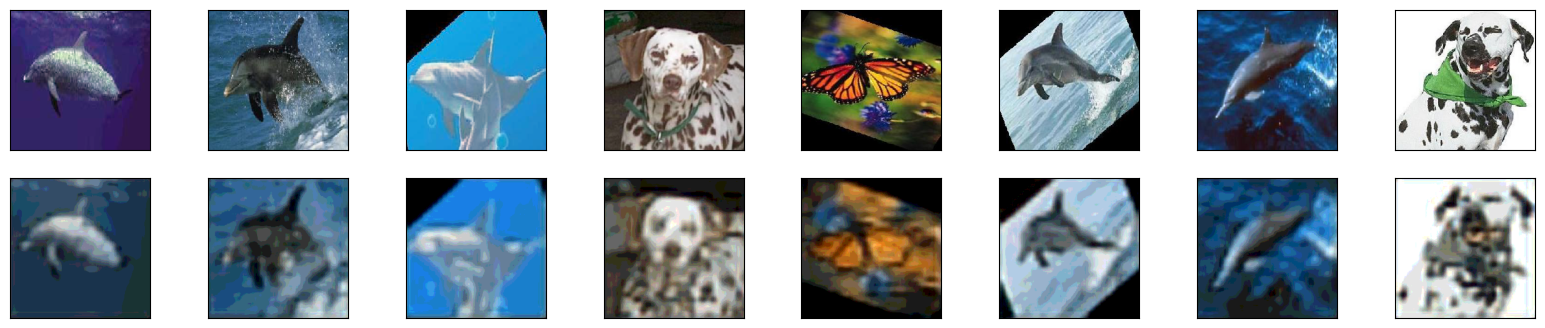

In [ ]:
n = 8
row = 2

plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(row, n, i + 1)
    plt.imshow(X_test_stacked[i].reshape(224, 224, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(row, n, i + 1 + n)
    plt.imshow(reconst_test[i].reshape(224, 224, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

In [ ]:
reduced_images_train = encoder_model.predict(X_train_stacked)
reduced_images_test = encoder_model.predict(X_test_stacked)
reduced_images = np.concatenate((reduced_images_train, reduced_images_test), axis=0)

2/2 [==============================] - 0s 10ms/step


In [ ]:
print("Dimensions before")
print(len(new_images))
print(new_images[0].shape)
print()
print("Dimensions after")
print(len(reduced_images))
print(reduced_images[0].shape)

Dimensions before
223
(224, 224, 3)

Dimensions after
223
(28, 28, 16)


##Augmentations
For computing augmentations I first need to split into training and test, because I will apply it just on the training set, to obtain a more generalized performance in the model.

**DIFFERENCES FRON THE EXAM**: In the exam I wrote that I would have applied rotations, flipping and zooming in as augmentations techniques, but in the end, after trying to implement all of them, I decided to focus only on the flipping because it was too time demanding finding a way to apply augmentations also on the bounding boxes.

In [ ]:
X_train, X_test, y_train, y_test, bboxes_train, bboxes_test = train_test_split(reduced_images, mapped_labels, bboxes, train_size=0.8, random_state=31, shuffle = False)

In [ ]:
print(type(bboxes))
print(bboxes.dtype)
print("")
print(type(bboxes_train))
print(bboxes_train.dtype)
print("")
print(type(bboxes_test))
print(bboxes_test.dtype)

<class 'numpy.ndarray'>
float64

<class 'numpy.ndarray'>
float64

<class 'numpy.ndarray'>
float64


In [ ]:
print(bboxes_train.shape)

(178, 4)


In [ ]:
datagen = ImageDataGenerator(
    horizontal_flip=True,)

augmented_images = []

for image in X_train:
    image = np.expand_dims(image, axis=0)

    # Apply the same augmentations to each image
    augmented_batch = datagen.flow(image, batch_size=1, shuffle=False, seed=42)
    augmented_images.append(augmented_batch[0][0])

augmented_images = np.array(augmented_images)

print(augmented_images.shape)

(178, 28, 28, 16)


/usr/local/lib/python3.10/dist-packages/keras/preprocessing/image.py:766: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 28, 28, 16) (16 channels).
  warnings.warn(


In [ ]:
print(type(bboxes))
print(bboxes.dtype)
print("")
print(type(bboxes_train))
print(bboxes_train.dtype)
print("")
print(type(bboxes_test))
print(bboxes_test.dtype)

<class 'numpy.ndarray'>
float64

<class 'numpy.ndarray'>
float64

<class 'numpy.ndarray'>
float64


Now I do the concatenation between the training set and the augmented images so my new X_train_conc has 356 images.

In [ ]:
X_train_conc = np.concatenate((X_train, augmented_images), axis=0)

Since the order of the augmetend images corresponds to the one of the X_train, and since y_train didn't change, to overcome the issues that now X_train_conc contains twice the amount of the labels in y_train, I decided to concatenate y_train with itself in order to create y_train_conc, which has the same dimension of X_train_conc.

In [ ]:
y_train_conc = np.concatenate((y_train, y_train), axis=0)

In [ ]:
n_classes = len(np.unique(y_train)) # number of classes in the training labels
print(n_classes)

3


Since my data augmentations is flipping the images, I need to flip also the bounding boxes. But since those are ratios, I just need to compute the complementary of the x values.

In [ ]:
augmented_bboxes = np.empty_like(bboxes_train)

for i, sublist in enumerate(bboxes_train):
    augmented_bboxes[i] = [1 - sublist[0], sublist[1], 1 - sublist[2], sublist[3]]

print(augmented_bboxes.shape)


(178, 4)


In [ ]:
print(bboxes_train[0])
print(augmented_bboxes[0])
#As we can see, the flipping is applying only to the first and the third values, that represents the x ratios.

[0.07179487 0.10666667 0.99487179 1.        ]
[0.92820513 0.10666667 0.00512821 1.        ]


In [ ]:
print(bboxes_train[0])
print(augmented_bboxes[0])
print(bboxes_train.shape)
print(augmented_bboxes.shape)

[0.07179487 0.10666667 0.99487179 1.        ]
[0.92820513 0.10666667 0.00512821 1.        ]
(178, 4)
(178, 4)


I concatenated the augmented boxes with the boxes of the training set.

In [ ]:
bboxes_conc = np.concatenate((bboxes_train, augmented_bboxes), axis=0)

In [ ]:
print(X_train_conc.shape)
print(y_train_conc.shape)
print(bboxes_conc.shape)
print()
print(X_test.shape)
print(y_test.shape)
print(bboxes_test.shape)

(356, 28, 28, 16)
(356,)
(356, 4)

(45, 28, 28, 16)
(45,)
(45, 4)


In [ ]:
print(f"X_train_conc: \n{type(X_train_conc)}\n{X_train_conc.shape}")
print("")
print(f"y_train_conc: \n{type(y_train_conc)}\n{y_train_conc.shape}")
print("")
print(f"bboxes_conc: \n{type(bboxes_conc)}\n{bboxes_conc.shape}")
print()
print(f"X_test: \n{type(X_test)}\n{X_test.shape}")
print("")
print(f"y_test: \n{type(y_test)}\n{y_test.shape}")
print("")
print(f"bboxes_test: \n{type(bboxes_test)}\n{bboxes_test.shape}")

X_train_conc: 
<class 'numpy.ndarray'>
(356, 28, 28, 16)

y_train_conc: 
<class 'numpy.ndarray'>
(356,)

bboxes_conc: 
<class 'numpy.ndarray'>
(356, 4)

X_test: 
<class 'numpy.ndarray'>
(45, 28, 28, 16)

y_test: 
<class 'numpy.ndarray'>
(45,)

bboxes_test: 
<class 'numpy.ndarray'>
(45, 4)


#5. Model
Now I create my model. As I said in the exam, I will apply a CNN followed by a multilayer perceptron, after I flattened the output of the CNN.
In the final layer the neural network will divide into two outputs layer, one for the image classification and one for the bounding boxes.
The first one is a dense layer with 3 neurons that corresponds to the total number of classes. Since I decided to transform the labels into integers I will use the sparse categorical cross entropy loss as loss function.
The second one is a dense layer with 4 channels that represents the components of the bounding boxes.


In [ ]:
def create_model(input_shape = (X_train_conc.shape[1], X_train_conc.shape[2], 16), learning_rate=0.001, dropout_rate=0.2, weight_reg='l2'):

    input_img = Input(shape=input_shape)

    model = Conv2D(64, kernel_size=(2, 2), input_shape=input_shape, padding="same", kernel_initializer=he_normal())(input_img)
    model = BatchNormalization()(model)
    model = Conv2D(32, kernel_size=(3, 3), padding="same", kernel_initializer=he_normal())(model)
    model = BatchNormalization()(model)
    model = Conv2D(16, kernel_size=(4, 4), padding="same", kernel_initializer=he_normal())(model)
    model = BatchNormalization()(model)
    model = MaxPooling2D(pool_size=(2, 2))(model)
    model = Flatten()(model)
    model = Dense(128, activation='relu', kernel_regularizer=weight_reg)(model)
    model = Dropout(dropout_rate)(model)
    model = Dense(64, activation='relu', kernel_regularizer=weight_reg)(model)
    model = Dropout(dropout_rate)(model)

    # Output layer for labels
    labels_output = Dense(3, activation='softmax', kernel_initializer='he_uniform', kernel_regularizer=weight_reg, name='labels')(model)

    # Output layer for bounding boxes
    bboxes_output = Dense(4, activation='sigmoid', kernel_initializer='he_uniform', kernel_regularizer=weight_reg, name='bboxes')(model)


    model = Model(inputs=input_img, outputs=[labels_output, bboxes_output])

    model.compile(loss={'labels': 'sparse_categorical_crossentropy', 'bboxes':'mean_squared_error'},
                  optimizer="adam", metrics={'labels':'accuracy', 'bboxes':'mean_squared_error'})
    return model


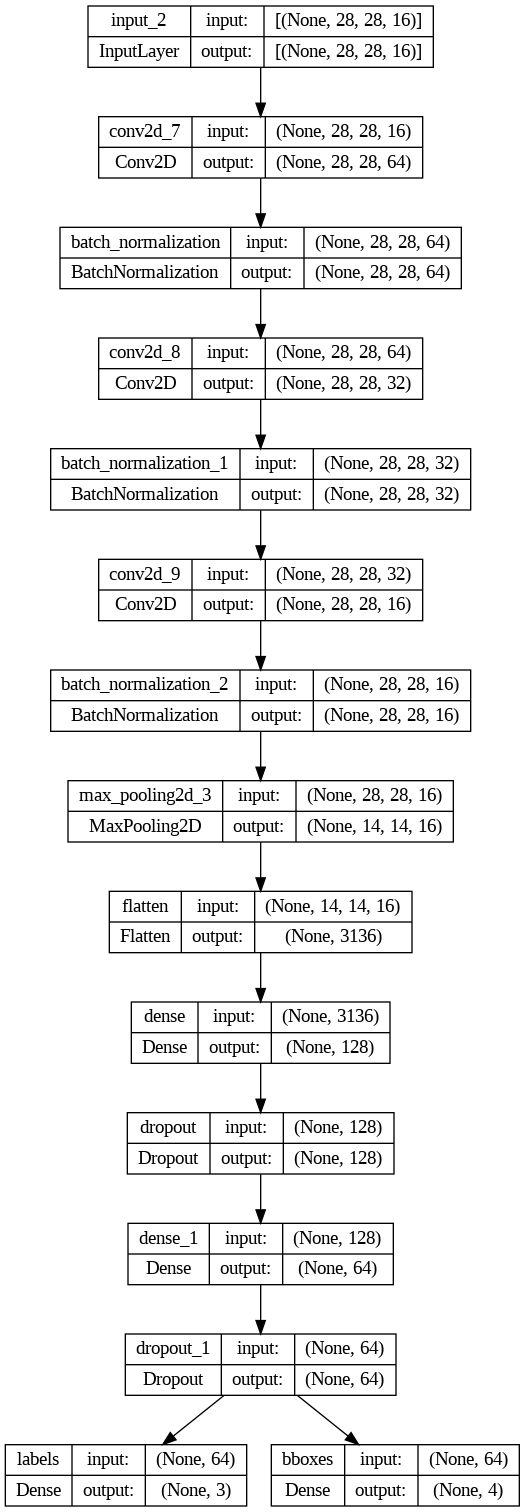

In [ ]:
input_shape = X_train_conc[1].shape
model_plot = create_model(input_shape)
plot_model(model_plot, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)

In [ ]:
print(y_train_conc.shape)
print()

(356,)



##Grid search
I will implement a grid search which is an otpimization technique to find the best hyperparameters to achieve a better performance in the model. In my exam I wrote that I could have performed a grid search even for finding the best activation function, but it was too time demanding so I decided to focus just on finding the best learning rate, dropout rate and weight regulariser.

In [ ]:
learning_rate = [0.001, 0.01, 0.1]

In [ ]:
dropout_rate=[0.2, 0.3, 0.4]

In [ ]:
weight_regularizer = ['l1', 'l2']

In [ ]:
#Dictionary for the hyperparameters
param_grid = {'learning_rate':learning_rate,
              'dropout_rate':dropout_rate,
              'weight_reg': weight_regularizer,}

def random_search_multitask(param_grid, samples=10):

  best_params = {}
  best_labels_params = {}
  best_bboxes_params = {}
  best_labels_acc = 0
  best_bboxes_mse = np.infty
  best_score = 0

  # Generate all the possible combinations of hyperparameters
  all_combinations = list(itertools.product(*param_grid.values()))

  sample_comb = random.sample(all_combinations, 10)
  random_params_dict = [dict(zip(param_grid.keys(), params)) for params in sample_comb]

  for sample in random_params_dict:
    lr = sample['learning_rate']
    dp = sample['dropout_rate']
    weight_reg = sample['weight_reg']

    sample_model = create_model(learning_rate= lr, dropout_rate=dp, weight_reg=weight_reg)

    sample_model.fit(X_train_conc, {'labels':y_train_conc, 'bboxes':bboxes_conc}, epochs=20,
                     batch_size=64, validation_data=(X_test, {'labels':y_test, 'bboxes':bboxes_test}), verbose=0)

    labels_pred = sample_model.predict(X_test)[0]
    bboxes_pred = sample_model.predict(X_test)[1]

    accuracy_labels = accuracy_score(y_test, np.argmax(labels_pred, axis=1))

    mse_bboxes = mean_squared_error(bboxes_test, bboxes_pred)

    mean_score = np.sqrt(accuracy_labels * (1 - mse_bboxes))

    if mean_score > best_score:
      best_score = mean_score
      best_params = sample

    if accuracy_labels > best_labels_acc:
      best_labels_acc = accuracy_labels
      best_labels_params = sample

    if mse_bboxes < best_bboxes_mse:
      best_bboxes_mse = mse_bboxes
      best_bboxes_params = sample

  final_values = {'best_overall': (best_score, best_params), 'best_labels': (best_labels_acc, best_labels_params),
                  'best_bboxes': (best_bboxes_mse, best_bboxes_params)}

  return final_values

best_models = random_search_multitask(param_grid)

print("The best overall model is:", best_models['best_overall'])
print("The best labels model is:", best_models['best_labels'])
print("The best bboxes model is:", best_models['best_bboxes'])

2/2 [==============================] - 0s 6ms/step
The best overall model is: (0.9126548462501185, {'learning_rate': 0.1, 'dropout_rate': 0.3, 'weight_reg': 'l2'})
The best labels model is: (0.9111111111111111, {'learning_rate': 0.1, 'dropout_rate': 0.3, 'weight_reg': 'l2'})
The best bboxes model is: (0.0690326187385857, {'learning_rate': 0.001, 'dropout_rate': 0.3, 'weight_reg': 'l2'})


After obtaining the result of the best combinations of hyperparameters I will use them in my model to obtain the best one.

In [ ]:
best_learning_rate = 0.001
best_dropout_rate = 0.3
best_weight_reg = 'l2'

In [ ]:
best_model = create_model(learning_rate = best_learning_rate,
                          dropout_rate = best_dropout_rate,
                          weight_reg = best_weight_reg)

best_model.fit(X_train_conc, y_train_conc,
               epochs = 20,
               batch_size = 64,
               verbose = 1
               )

Epoch 1/20
6/6 [==============================] - 3s 13ms/step - loss: 5.3748 - labels_loss: 1.0826 - bboxes_loss: 0.8848 - labels_accuracy: 0.5506 - bboxes_mean_squared_error: 0.8848
Epoch 2/20
6/6 [==============================] - 0s 13ms/step - loss: 4.7280 - labels_loss: 0.6144 - bboxes_loss: 0.7922 - labels_accuracy: 0.7500 - bboxes_mean_squared_error: 0.7922
Epoch 3/20
6/6 [==============================] - 0s 12ms/step - loss: 4.4998 - labels_loss: 0.5696 - bboxes_loss: 0.7143 - labels_accuracy: 0.7753 - bboxes_mean_squared_error: 0.7143
Epoch 4/20
6/6 [==============================] - 0s 13ms/step - loss: 4.1925 - labels_loss: 0.5067 - bboxes_loss: 0.5865 - labels_accuracy: 0.7809 - bboxes_mean_squared_error: 0.5865
Epoch 5/20
6/6 [==============================] - 0s 12ms/step - loss: 4.0092 - labels_loss: 0.4960 - bboxes_loss: 0.5338 - labels_accuracy: 0.8062 - bboxes_mean_squared_error: 0.5338
Epoch 6/20
6/6 [==============================] - 0s 11ms/step - loss: 3.7530 - 

In [ ]:
train_predictions_labels, train_predictions_bboxes = best_model.predict(X_train_conc)
test_predictions_labels, test_predictions_bboxes = best_model.predict(X_test)

2/2 [==============================] - 0s 6ms/step


#6. Model evaluation
As stated in my exam, I will use as metrics of evaluation the accuracy and the F1 score. Regarding the bounding boxes I will evaluate the performance with the MSE to see the result of my model.

In [ ]:
train_pred_labels = np.argmax(train_predictions_labels, axis=1)
test_pred_labels = np.argmax(test_predictions_labels, axis=1)

train_accuracy = accuracy_score(y_train_conc, train_pred_labels)
test_accuracy = accuracy_score(y_test, test_pred_labels)

train_f1 = f1_score(y_train_conc, train_pred_labels, average='weighted')
test_f1 = f1_score(y_test, test_pred_labels, average='weighted')

train_mse_bboxes = mean_squared_error(bboxes_conc, train_predictions_bboxes)
test_mse_bboxes = mean_squared_error(bboxes_test, test_predictions_bboxes)

print("Train Accuracy:", train_accuracy)
print("Train F1 Score:", train_f1)
print("Train Mean Squared Error (Bounding Boxes):", train_mse_bboxes)
print()
print("Test Accuracy:", test_accuracy)
print("Test F1 Score:", test_f1)
print("Test Mean Squared Error (Bounding Boxes):", test_mse_bboxes)

Train Accuracy: 0.9747191011235955
Train F1 Score: 0.9750599018453797
Train Mean Squared Error (Bounding Boxes): 0.27045920985479227

Test Accuracy: 0.8444444444444444
Test F1 Score: 0.8467181467181468
Test Mean Squared Error (Bounding Boxes): 0.24607342207098204


I implemented a confusion matrix to see more accurately the performance of my model.

In [ ]:
cm = confusion_matrix(y_test, test_pred_labels)
print(cm)

[[11  0  0]
 [ 2 17  0]
 [ 4  1 10]]
